In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
#import mlflow

In [ ]:
mlflow_uri = "sqlite:///mlflow.db"
mlflow.set_tracking_uri(mlflow_uri)

In [ ]:
exp_id = mlflow.create_experiment("ver_01")
exp_id

In [2]:
df = pd.read_csv("fer2013.csv")
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [3]:
# 샘플 불규형을 해소하기 위해 (angry, disgust) 감정은 하나의 라벨로 통합
df['emotion'] = df['emotion'].map({0:0, 1:0, 2:1, 3:2, 4:3, 5:4, 6:5})
# 0 : angry or disgust, 1 : fear, 2 : happy, 3: sad, 4 : surprise, 5 : neutral 로 변경

In [4]:
image_size = (48, 48)
pixels = df['pixels'].tolist()
width, height = 48, 48
faces = []
for pixel_sequence in pixels:
    face = [int(pixel) for pixel in pixel_sequence.split(' ')]
    face = np.asarray(face).reshape(width, height)
    face = cv2.resize(face.astype('uint8'), image_size)
    faces.append(face.astype('float32'))

faces = np.asarray(faces)
faces = np.expand_dims(faces, -1)

In [5]:
faces.shape

(35887, 48, 48, 1)

In [6]:
x = faces.astype('float32')
x = x / 255.0

x = x - 0.5
x = x * 2.0

In [7]:
emotions = pd.get_dummies(df[['emotion']], columns=['emotion'])
emotions

,emotion_0,emotion_1,emotion_2,emotion_3,emotion_4,emotion_5
0,1,0,0,0,0,0
1,1,0,0,0,0,0
2,0,1,0,0,0,0
3,0,0,0,1,0,0
4,0,0,0,0,0,1
...,...,...,...,...,...,...
35882,0,0,0,0,0,1
35883,0,0,1,0,0,0
35884,1,0,0,0,0,0
35885,0,0,1,0,0,0


In [8]:
num_samples, num_classes = emotions.shape
num_train_samples = int(0.8 * num_samples)

# Train
x_train = x[:num_train_samples]
y_train = emotions[:num_train_samples]

# val
x_val = x[num_train_samples:]
y_val = emotions[num_train_samples:]

train_data = (x_train, y_train)
val_data = (x_val, y_val)

In [9]:
print('x_train shape : ', x_train.shape)
print('x_val shape : ', x_val.shape)
print('y_train shape : ', y_train.shape)
print('y_val shape : ', y_val.shape)

x_train shape :  (28709, 48, 48, 1)
x_val shape :  (7178, 48, 48, 1)
y_train shape :  (28709, 6)
y_val shape :  (7178, 6)


# 모델 구성 및 수행

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
import seaborn as sns
import cv2
import sys

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import load_model
from keras.layers import Activation, Convolution2D, Dropout, Conv2D, Dense, ZeroPadding2D, ReLU
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Flatten
from keras.models import Model, load_model
from keras.layers import Input, Add
from keras.layers import MaxPooling2D
from keras.layers import SeparableConv2D
from keras import layers
import keras

In [11]:
# SelfCNN

input_shape = (48, 48, 1)
num_classes = 6

model = Sequential()
model.add(Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='valid', input_shape=input_shape))
model.add(BatchNormalization(axis=3))
model.add(Activation('relu'))
model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same'))
model.add(BatchNormalization(axis=3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='valid'))
model.add(BatchNormalization(axis=3))
model.add(Activation('relu'))
model.add(Convolution2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same'))
model.add(BatchNormalization(axis=3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='valid'))
model.add(BatchNormalization(axis=3))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 46, 46, 32)        128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 46, 46, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 46, 46, 64)        256       
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 46, 46, 64)        0

In [ ]:
batch_size=32
num_epochs=80
num_classes=6

data_generator = ImageDataGenerator(featurewise_center=False,
                                   featurewise_std_normalization=False,
                                   rotation_range=10,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True)

keras.backend.clear_session()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

train_faces, train_emotions = train_data
history = model.fit(data_generator.flow(train_faces, train_emotions, batch_size),
                             epochs=80, verbose=1, validation_data=val_data)

In [ ]:
from sklearn.metrics import classification_report

plt.figure(figsize=(10, 5))

# 손실 그래프
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Inception V3 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper right')

# 훈련 정확도 그래프
plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Inception V3 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='lower right')
plt.tight_layout()
plt.show()

In [ ]:
y_pred = model.predict(x_val)

print(classification_report(np.argmax(np.array(y_val), axis=1), np.argmax(y_pred, axis=1)))

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# 0 : angry/disgust, 1 : fear, 2 : happy, 3 : sad, 4 : surprise, 5 : neutral
from sklearn.metrics import confusion_matrix

conf = confusion_matrix(np.argmax(np.array(y_val), axis=1), np.argmax(y_pred, axis=1))
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels = ['angry', 'fear', 'happy', 'sad','surprise', 'neutral'])
cm_display.plot()

In [ ]:
# model.save('emotion_model_selfCNN2.h5')

In [ ]:
with mlflow.start_run(experiment_id =4): # experiment_id 설정!!

    mlflow.sklearn.autolog()
    
    
    model = load_model('emotion_model_selfCNN2.h5', compile=False)
    pred = model.predict(x_val)
    mlflow.log_metric("mse", mean_squared_error(y_val, pred))
    mlflow.sklearn.log_model(model, "model", registered_model_name='base')
    
    mlflow.sklearn.autolog(disable=True)

# 사진 불러와서 얼굴/표정 예측

In [4]:
def load_detection_model(model_path):
    detection_model = cv2.CascadeClassifier(model_path)
    return detection_model

def detect_faces(detection_model, gray_image_array):
    return detection_model.detectMultiScale(gray_image_array, 1.3, 5)

def draw_bounding_box(face_coordinates, image_array, color):
    x, y, w, h = face_coordinates
    cv2.rectangle(image_array, (x, y), (x+w, y+h), color, 2)

def apply_offsets(face_coordinates, offsets):
    x, y, width, height = face_coordinates
    x_off, y_off = offsets
    return (x - x_off, x+width+x_off, y-y_off, y+height+y_off)

def draw_text(coordinates, image_array, text, color, x_offset=0, y_offset=0, font_scale=0.5, thickness=2):
    x, y = coordinates[:2]
    cv2.putText(image_array, text, (x+x_offset, y+y_offset),cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness, cv2.LINE_AA)

def preprocess_input(x, v2=True):
    x = x.astype('float32')
    x = x / 255.0
    if v2:
        x = x - 0.5
        x = x * 2.0
    return x

In [5]:
image_path = "football.jpg" # 사진 파일 이름
detection_model_path = 'haarcascade_frontalface_default.xml'

emotion_model_path = 'emotion_model_selfCNN2.h5'
emotion_labels = {0:'angry', 1:'fear', 2:'happy', 3:'sad', 4:'surprise', 5:'neutral'}
font = cv2.FONT_HERSHEY_SIMPLEX

emotion_offsets = (0, 0)

In [8]:
# model load
face_detection = load_detection_model(detection_model_path)
emotion_classifier = load_model(emotion_model_path, compile=False)
emotion_target_size = emotion_classifier.input_shape[1:3]

rgb_image = cv2.imread(image_path)
gray_image = cv2.imread(image_path, 0)

engagement 가중치 공식 논문 참고 : https://europepmc.org/article/med/36105662

In [9]:
def highest_emotion(positive, neutral, negative):
    if positive == max([positive, neutral, negative]):
        return 'positive'
    elif neutral == max([positive, neutral, negative]):
        return 'neutral'
    else:
        return 'negative'
    
def engagement_score(scores):
    if ((scores[5] > 0.6) | (scores[2] > 0.5) | (scores[4] > 0.6) | (scores[0] > 0.2) | (scores[1] > 0.3) | (scores[3] > 0.3)):
        return ((scores[0] * 0.25) + (scores[1] * 0.3) + (scores[2] * 0.6) + (scores[3] * 0.3) + (scores[4] * 0.6) + (scores[5] * 0.9))
    else:
        return 0

1/1 [==============================] - 0s 54ms/step
positive percentage(%) :  21
neutral percentage(%) :  49
negative percentage(%) :  30
engagement percentage(%) :  48


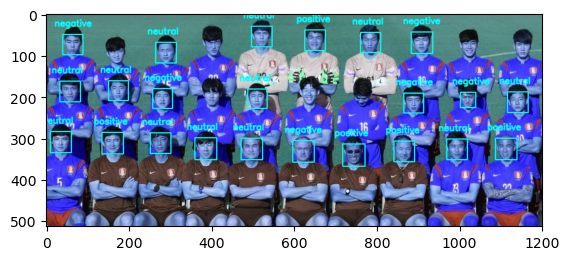

In [10]:
positives = []
neutrals = []
negatives = []
engagements = []
faces = detect_faces(face_detection, rgb_image)
for face_coordinates in faces:

    x1, x2, y1, y2 = apply_offsets(face_coordinates, emotion_offsets)
    gray_face = gray_image[y1:y2, x1:x2]
    gray_face = cv2.resize(gray_face, (emotion_target_size))

    gray_face = preprocess_input(gray_face, True)
    gray_face = np.expand_dims(gray_face, 0)
    gray_face = np.expand_dims(gray_face, -1)

    emotion_label_arg = np.argmax(emotion_classifier.predict(gray_face))
    engagement = engagement_score(emotion_classifier.predict(gray_face)[0])
    positive = emotion_classifier.predict(gray_face)[0][2] + emotion_classifier.predict(gray_face)[0][4]
    neutral = emotion_classifier.predict(gray_face)[0][5]
    negative = emotion_classifier.predict(gray_face)[0][0] + emotion_classifier.predict(gray_face)[0][1] + emotion_classifier.predict(gray_face)[0][3]
    positives.append(positive)
    neutrals.append(neutral)
    negatives.append(negative)
    engagements.append(engagement)
    emotion_text = highest_emotion(positive, neutral, negative)
    color = (0, 255, 255)

    draw_bounding_box(face_coordinates, rgb_image, color)
    draw_text(face_coordinates, rgb_image, emotion_text, color, -20, -20, 0.7, 2)

plt.imshow(rgb_image)
cv2.imwrite('result_emotion_image.jpg', rgb_image)
print('positive percentage(%) : ',int(round(sum(positives) / len(positives),2) * 100))
print('neutral percentage(%) : ',int(round(sum(neutrals) / len(neutrals),2) * 100))
print('negative percentage(%) : ',int(round(sum(negatives) / len(negatives),2) * 100))
print('engagement percentage(%) : ',int(round(sum(engagements) / len(engagements),2) * 100))

results = {
    "Positive Response(%)" : int(round(sum(positives) / len(positives),2) * 100),
    "Neutral Response(%)" : int(round(sum(neutrals) / len(neutrals),2) * 100),
    "Negative Response(%)" : int(round(sum(negatives) / len(negatives),2) * 100),
    "Engagement(%)" : int(round(sum(engagements) / len(engagements),2) * 100)
}

In [12]:
import json

with open('json_results.json', 'w') as f:
    json.dump(results, f)